# Load packages

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import gdown

# Download dataset of non-numeric characters: +-x/().

In [2]:
url = 'https://drive.google.com/uc?id=1hjdN2Jo8Dli8YC7NskSMsodakTWU9lR0'
output = '/datasset.zip'

gdown.download(url, output, quiet=False)

!unzip -qq /datasset.zip -d /
!rm /datasset.zip

Downloading...
From: https://drive.google.com/uc?id=1hjdN2Jo8Dli8YC7NskSMsodakTWU9lR0
To: /datasset.zip
100%|██████████| 85.6M/85.6M [00:01<00:00, 51.1MB/s]


# Load MNIST dataset from Tensorflow hub
The dataset consists of the digits from 0 to 9

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
for img_index, img in enumerate(x_train):
    (_, new_img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    x_train[img_index] = new_img
for img_index, img in enumerate(x_test):
    (_, new_img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    x_test[img_index] = new_img

# Merge datasets

In [5]:
IMG_DIMS = 28
LEARNING_RATE = 1e-3
TOTAL_EPOCHES = 10
id2label = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: '+',
    11: '-',
    12: 'times',
    13: 'forward_slash',
    14: '(',
    15: ')',
}

label2id = {value: key for key, value in id2label.items()}
NUMBER_OF_LABELS = len(id2label)
BATCH_SIZE = 32

In [6]:
dataset_path = Path('/dataset')
non_digit_images, non_digit_labels = [], []
kernel = np.ones((3, 3), np.uint8)
for img_path in dataset_path.glob('**/*.jpg'):
    img = 255-cv2.imread(img_path.as_posix(), cv2.IMREAD_GRAYSCALE)
    img = cv2.dilate(img, kernel)
    (_, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img = cv2.resize(img, (IMG_DIMS, IMG_DIMS), interpolation = cv2.INTER_AREA)
    non_digit_images.append(img)
    non_digit_labels.append(label2id[img_path.parent.stem])

non_digit_images = np.stack(non_digit_images, axis=0)
non_digit_labels = np.stack(non_digit_labels, axis=0)

In [7]:
X = np.concatenate([x_train, x_test, non_digit_images])[:, :, :, np.newaxis] / 255
y = np.concatenate([y_train, y_test, non_digit_labels])

# Train model



*   input layer: [.,784]
*   layer: Conv1 -> ReLu -> MaxPool: [.,14,14,36]
*   layer: Conv2 -> ReLu -> MaxPool: [.,7,7,36]
*   layer: Conv3 -> ReLu -> MaxPool: [.,4,4,36]
*   layer: FC -> ReLu: [.,576]
*   output layer: FC -> ReLu: [.,10]



In [8]:
def build_model(num_classes, learning_rate):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(36, 3, input_shape=(IMG_DIMS, IMG_DIMS, 1), activation='relu'),
        tf.keras.layers.MaxPool2D(padding='same'),
        tf.keras.layers.Conv2D(36, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(padding='same'),
        tf.keras.layers.Conv2D(36, 3,  activation='relu'),
        tf.keras.layers.MaxPool2D(padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(576, activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [9]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1993)

Epoch 1/10
4028/4031 [============================>.] - ETA: 0s - loss: 0.1169 - sparse_categorical_accuracy: 0.9651
Epoch 00001: saving model to /neural_net_models/fold_1/model_01-0.0381.ckpt
4031/4031 [==============================] - 26s 4ms/step - loss: 0.1168 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.0381 - val_sparse_categorical_accuracy: 0.9890 - lr: 0.0010
Epoch 2/10
4027/4031 [============================>.] - ETA: 0s - loss: 0.0375 - sparse_categorical_accuracy: 0.9889
Epoch 00002: saving model to /neural_net_models/fold_1/model_02-0.0292.ckpt
4031/4031 [==============================] - 17s 4ms/step - loss: 0.0376 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9915 - lr: 9.9999e-04
Epoch 3/10
4031/4031 [==============================] - ETA: 0s - loss: 0.0280 - sparse_categorical_accuracy: 0.9918
Epoch 00003: saving model to /neural_net_models/fold_1/model_03-0.0308.ckpt
4031/4031 [==============================] - 18

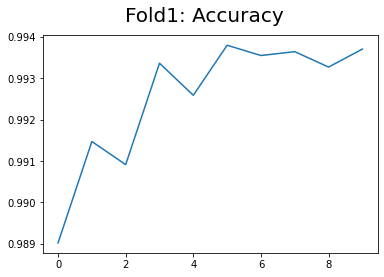

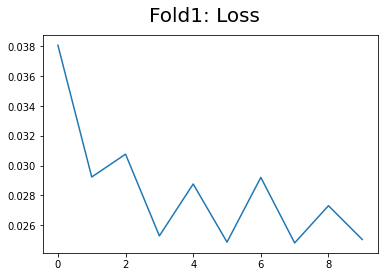

Epoch 1/10
4022/4031 [============================>.] - ETA: 0s - loss: 0.1137 - sparse_categorical_accuracy: 0.9662
Epoch 00001: saving model to /neural_net_models/fold_2/model_01-0.0361.ckpt
4031/4031 [==============================] - 18s 4ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.0361 - val_sparse_categorical_accuracy: 0.9891 - lr: 0.0010
Epoch 2/10
4025/4031 [============================>.] - ETA: 0s - loss: 0.0389 - sparse_categorical_accuracy: 0.9887
Epoch 00002: saving model to /neural_net_models/fold_2/model_02-0.0267.ckpt
4031/4031 [==============================] - 17s 4ms/step - loss: 0.0390 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.0267 - val_sparse_categorical_accuracy: 0.9915 - lr: 9.9999e-04
Epoch 3/10
4019/4031 [============================>.] - ETA: 0s - loss: 0.0283 - sparse_categorical_accuracy: 0.9917
Epoch 00003: saving model to /neural_net_models/fold_2/model_03-0.0212.ckpt
4031/4031 [==============================] - 17

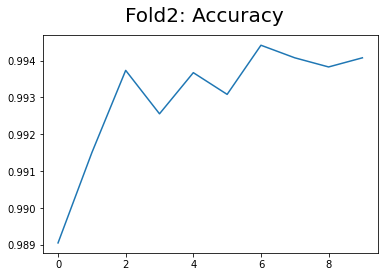

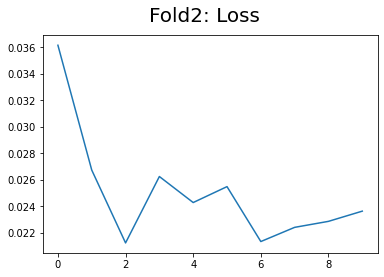

Epoch 1/10
4026/4031 [============================>.] - ETA: 0s - loss: 0.1183 - sparse_categorical_accuracy: 0.9649
Epoch 00001: saving model to /neural_net_models/fold_3/model_01-0.0358.ckpt
4031/4031 [==============================] - 18s 4ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.0358 - val_sparse_categorical_accuracy: 0.9890 - lr: 0.0010
Epoch 2/10
4019/4031 [============================>.] - ETA: 0s - loss: 0.0377 - sparse_categorical_accuracy: 0.9889
Epoch 00002: saving model to /neural_net_models/fold_3/model_02-0.0239.ckpt
4031/4031 [==============================] - 18s 4ms/step - loss: 0.0377 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.0239 - val_sparse_categorical_accuracy: 0.9929 - lr: 9.9999e-04
Epoch 3/10
4023/4031 [============================>.] - ETA: 0s - loss: 0.0280 - sparse_categorical_accuracy: 0.9917
Epoch 00003: saving model to /neural_net_models/fold_3/model_03-0.0202.ckpt
4031/4031 [==============================] - 17

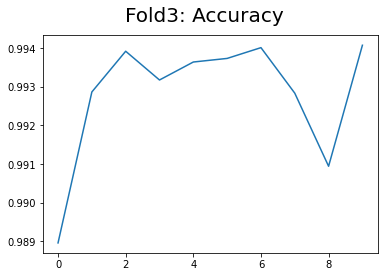

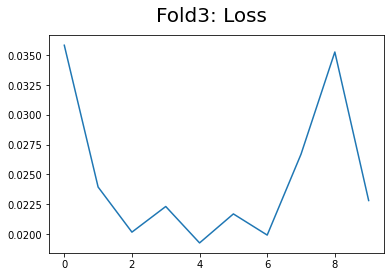

Epoch 1/10
4031/4031 [==============================] - ETA: 0s - loss: 0.1143 - sparse_categorical_accuracy: 0.9662
Epoch 00001: saving model to /neural_net_models/fold_4/model_01-0.0350.ckpt
4031/4031 [==============================] - 19s 4ms/step - loss: 0.1143 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.0350 - val_sparse_categorical_accuracy: 0.9890 - lr: 0.0010
Epoch 2/10
4022/4031 [============================>.] - ETA: 0s - loss: 0.0379 - sparse_categorical_accuracy: 0.9888
Epoch 00002: saving model to /neural_net_models/fold_4/model_02-0.0335.ckpt
4031/4031 [==============================] - 17s 4ms/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.0335 - val_sparse_categorical_accuracy: 0.9905 - lr: 9.9999e-04
Epoch 3/10
4024/4031 [============================>.] - ETA: 0s - loss: 0.0288 - sparse_categorical_accuracy: 0.9915
Epoch 00003: saving model to /neural_net_models/fold_4/model_03-0.0240.ckpt
4031/4031 [==============================] - 18

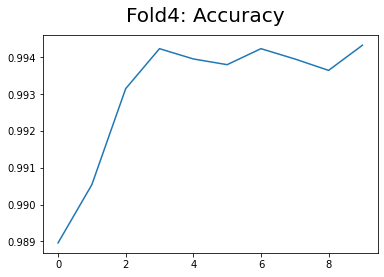

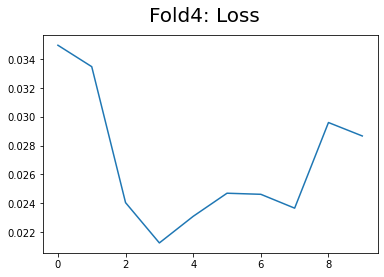

Epoch 1/10
4021/4031 [============================>.] - ETA: 0s - loss: 0.1111 - sparse_categorical_accuracy: 0.9669
Epoch 00001: saving model to /neural_net_models/fold_5/model_01-0.0351.ckpt
4031/4031 [==============================] - 18s 4ms/step - loss: 0.1109 - sparse_categorical_accuracy: 0.9670 - val_loss: 0.0351 - val_sparse_categorical_accuracy: 0.9899 - lr: 0.0010
Epoch 2/10
4023/4031 [============================>.] - ETA: 0s - loss: 0.0379 - sparse_categorical_accuracy: 0.9886
Epoch 00002: saving model to /neural_net_models/fold_5/model_02-0.0277.ckpt
4031/4031 [==============================] - 17s 4ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.0277 - val_sparse_categorical_accuracy: 0.9920 - lr: 9.9999e-04
Epoch 3/10
4021/4031 [============================>.] - ETA: 0s - loss: 0.0292 - sparse_categorical_accuracy: 0.9912
Epoch 00003: saving model to /neural_net_models/fold_5/model_03-0.0230.ckpt
4031/4031 [==============================] - 18

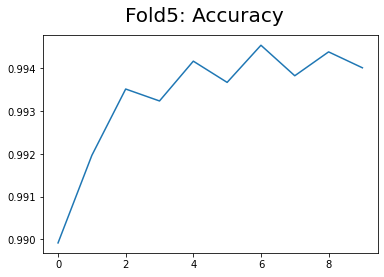

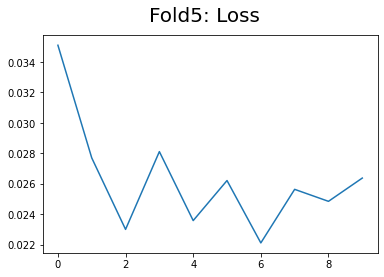

In [10]:
for fold_index, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    x_train, y_train = X[train_index], y[train_index]
    x_test, y_test = X[test_index], y[test_index]
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(len(x_test)).batch(BATCH_SIZE)

    DECAY_STEPS = 4 * len(train_dataset) // BATCH_SIZE


    lr_decayed_fn = tf.keras.experimental.CosineDecay(LEARNING_RATE, DECAY_STEPS)
    callback = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

    checkpoint_path = "/neural_net_models/fold_" + str(fold_index) + "/model_{epoch:02d}-{val_loss:.4f}.ckpt"

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)

    model = build_model(NUMBER_OF_LABELS, LEARNING_RATE)
    
    
    history = model.fit(x=train_dataset,
        validation_data=test_dataset,
        epochs=TOTAL_EPOCHES,
        callbacks=[callback, cp_callback]
    )

    fig = plt.figure()
    plt.plot(history.history["val_sparse_categorical_accuracy"])
    fig.suptitle(f"Fold{fold_index}: Accuracy", fontsize=20)
    plt.show()
    fig = plt.figure()
    plt.plot(history.history["val_loss"])
    fig.suptitle(f"Fold{fold_index}: Loss", fontsize=20)
    plt.show()